<a href="https://colab.research.google.com/github/GabrielaRomoM/TAM-2025-2/blob/main/Tareas/TAM_Cuaderno7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias y carga de datos

In [1]:
from IPython.display import clear_output
# Importar todas las librerias necesarias instalando RAPIDS en el entorno Colab
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com

#https://drive.google.com/file/d/1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP/view?usp=sharing

FILEID = "1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O tanjiro.jpeg && rm -rf /tmp/cookies.txt
clear_output()

In [2]:
import os
import cudf
import numpy as np
import cupy as cp
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import cupyx.scipy.sparse as sp
import cupyx.scipy.sparse.linalg as spla

from matplotlib.image import imread
from cuml.cluster import KMeans, DBSCAN
from sklearn.cluster import SpectralClustering
from cuml.metrics.cluster import silhouette_score
from cuml.manifold import UMAP
from cuml.decomposition import PCA
from cuml.neighbors import NearestNeighbors
warnings.filterwarnings('ignore')

# Ejercicio 1

Realice una comparación de los métodos de clustering vistos, para generar una segmentación de imagen a color, incluyendo la información de ubicación de cada pixel (ver Cuaderno guía [tanjiro](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/tanjiro.ipynb)). Varie la cantidad de grupos (niveles o clases de segmentación) $k\in\{3,5,7,9\}$ y presente los scores de inercia y silueta conseguidos.

Image shape: 125x125x3


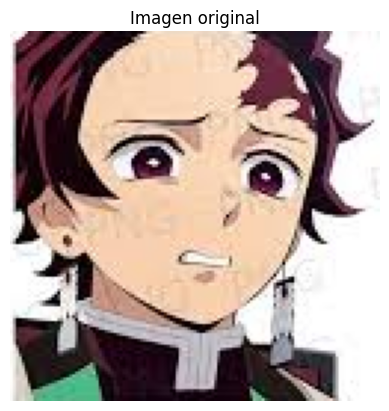

In [3]:
image = imread(os.path.join("tanjiro.jpeg"))
image = image[50:175, 50:175, :]   # recorte
r, c, ch = image.shape
pixels = image.reshape(-1, 3).astype(cp.float32)
print(f"Image shape: {r}x{c}x{ch}")

plt.imshow(image)
plt.title("Imagen original")
plt.axis("off")
plt.show()

In [4]:
#Función para mostrar los resultados
def show_segmentation(results_dict, method_name):
    """
    Muestra todas las segmentaciones en una misma fila para un método dado.
    results_dict: diccionario {k: labels}
    """
    fig, axes = plt.subplots(1, len(results_dict), figsize=(16, 4))
    for ax, (k, labels) in zip(axes, results_dict.items()):
        segmented = labels.reshape(r, c)
        ax.imshow(segmented, cmap="viridis")
        ax.set_title(f"{method_name}\n(k={k})")
        ax.axis("off")
    plt.tight_layout(); plt.show()

#Agregar coordenadas espaciales
ys_flat = cp.repeat(cp.arange(r), c)[:, None]
xs_flat = cp.tile(cp.arange(c), r)[:, None]
coords = cp.hstack([xs_flat, ys_flat]).astype(cp.float32)

#Combinanr [R, G, B, x, y]
X = cp.hstack([pixels, coords])

#Convertir a GPU dataframe (cudf)
X_gpu = cudf.DataFrame(X, columns=["R", "G", "B", "x", "y"])

##K-means

Dado un conjunto de datos no supervisado:
\begin{equation}
X = \{ \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n \}, \quad \mathbf{x}_i \in \mathbb{R}^P
\end{equation}

El problema de optimización del algoritmo K-means, para agrupar los datos de entrada en $K$ grupos disjuntos, se puede definir como:

\begin{align}
\hat{\boldsymbol{\mu}}_k =& \arg\min_{\boldsymbol{\mu}_k} \sum_{k=1}^{K} \sum_{\mathbf{x} \in C_k} \|\mathbf{x} - \boldsymbol{\mu}_k\|^2\\
\text{s.t.} & \quad C_k = \left\{\mathbf{x}_n : k=\min_{j}\|\mathbf{x} - \boldsymbol{\mu}_k\|\right\} \\
& \quad C_k \cap C_{k'} = \emptyset
\end{align}

donde el centro se define como:

\begin{equation}
\boldsymbol{\mu}_k = \frac{1}{|C_k|} \sum_{\mathbf{x} \in C_k} \mathbf{x}
\end{equation}

Y la actualización de los mismos depende de:

\begin{equation}
\boldsymbol{\mu}_k^{(t+1)} = \frac{1}{|C_k^{(t)}|} \sum_{\mathbf{x} \in C_k^{(t)}} \mathbf{x}
\end{equation}

**El algoritmo en acción:**

- La clase *KMeans* aplica un algoritmo optimizado por defecto. Para obtener el algoritmo K-Means original (solo con fines educativos), debe establecer *init="random"*, *n_init = 1* and *algorithm="full"*. Estos hiperparámetros se explicarán a continuación.

- Ejecutemos el algoritmo K-Means para 1, 2 y 3 iteraciones, para ver **cómo se mueven los centroides**:

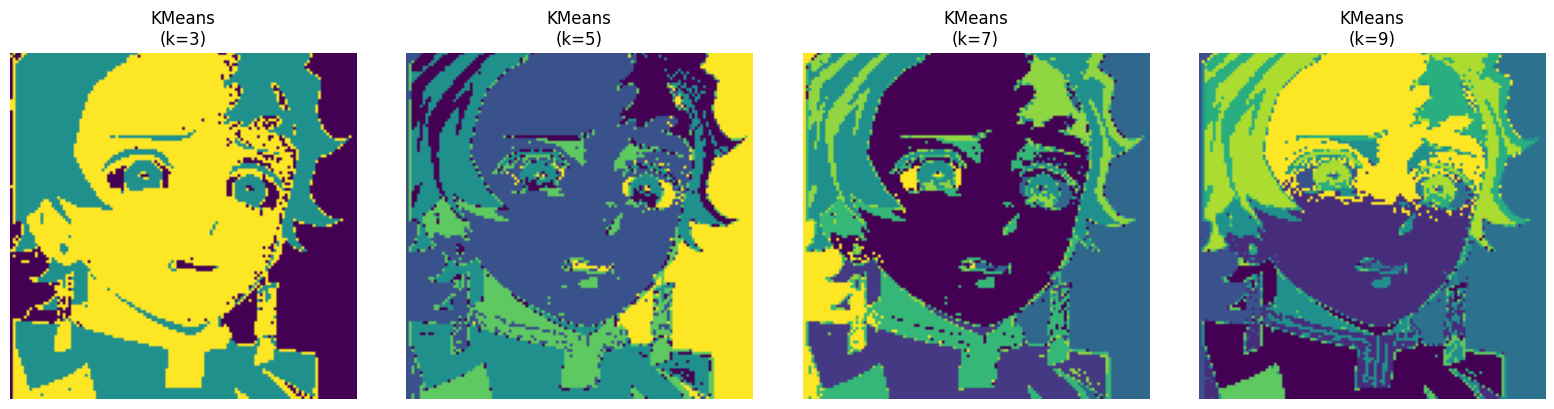

In [5]:
#Parámetros
k_values = [3, 5, 7, 9]
results = []
kmeans_segmentations = {}

#Kmeans
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_gpu)
    labelskm = kmeans.labels_.to_numpy()

    inertia = float(kmeans.inertia_) #solo si KMeans tiene inercia
    sil = float(silhouette_score(X_gpu, kmeans.labels_))
    results.append(("KMeans", k, inertia, sil))
    kmeans_segmentations[k] = labelskm

#Mostrar Resultados
show_segmentation(kmeans_segmentations, "KMeans")

## DBSCAN

- Density-Based Spatial Clustering of Applications with Noise (DBSCAN) es un algoritmo de clustering que considera la densidad de puntos en una región.

- Puede ser útil para estructuras no lineales y para la detección de atípicos.

- Su funcionamiento se centra en la estimación de vecindarios:


\begin{equation}
N_{\varepsilon}(p) = \{q \in D \mid \text{dist}(p, q) \leq \varepsilon\}
\end{equation}

- Y tiene en cuenta la restricción:

\begin{equation}
|N_{\varepsilon}(p)| \geq \text{minPts}
\end{equation}

- Un punto es considerado alcanzable (core-point), si:

\begin{equation}
q \in N_{\varepsilon}(p) \quad \text{and} \quad |N_{\varepsilon}(p)| \geq \text{minPts}
\end{equation}

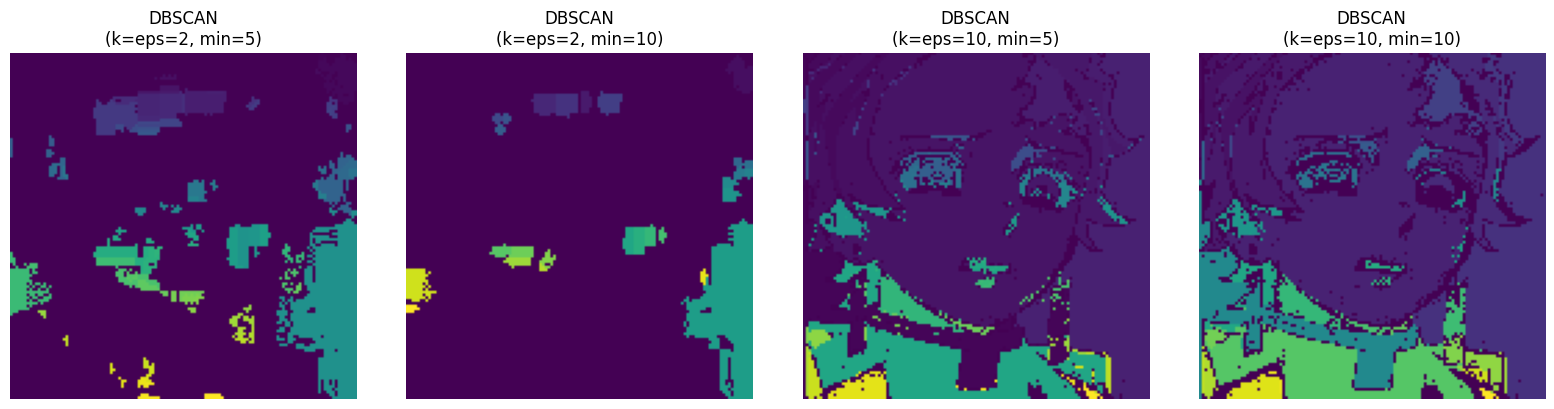

In [6]:
#Párametros
eps_values = [2, 10]
min_samples_values = [5, 10]
dbscan_segmentations = {}

# DBSCAN
for e in eps_values:
    for m in min_samples_values:
        dbscan = DBSCAN(eps=e, min_samples=m)
        labels_db = dbscan.fit_predict(X_gpu)

        #Contar clusters válidos (sin el ruido -1)
        unique_labels = cp.unique(labels_db)
        n_clusters = len(unique_labels[unique_labels != -1])
        if n_clusters > 1:
            sil_db = float(silhouette_score(X_gpu, labels_db))
        else:
            sil_db = float('nan')
        results.append(("DBSCAN","-", None, sil_db))
        # Guardar segmentación
        dbscan_segmentations[f"eps={e}, min={m}"] = labels_db.to_numpy()

#Mostrar Resultados
show_segmentation(dbscan_segmentations, "DBSCAN")

## Spectral Clustering

- Se basa en la similitud entre puntos (Gaussian kernel)

\begin{equation}
w_{nm} = \exp\left(-\frac{\|x_n - x_m\|^2}{2\sigma^2}\right)
\end{equation}

- Tiene en cuenta el grado de la matriz de similitud para ser robusta a datos atípicos:

\begin{equation}
d_{nn} = \sum_{m} w_{nm}
\end{equation}

- Posteriormente, se encuenta la matríz Laplaciano:

\begin{equation}
L = D - W
\end{equation}

- Y se normaliza:

\begin{equation}
L_{sym} = D^{-\frac{1}{2}} L D^{-\frac{1}{2}} = I - D^{-\frac{1}{2}} W D^{-\frac{1}{2}}
\end{equation}

- Otra alternativa de normalización:

\begin{equation}
L_{rw} = D^{-1} L = I - D^{-1} W
\end{equation}

- Se descompone en valores y vectores propios:

\begin{equation}
L \mathbf{u} = \lambda \mathbf{u}
\end{equation}

- Finalmente se aplica un algoritmo tradicional de clustering, e.g., Kmeans, sobre los vectores propios escogidos.

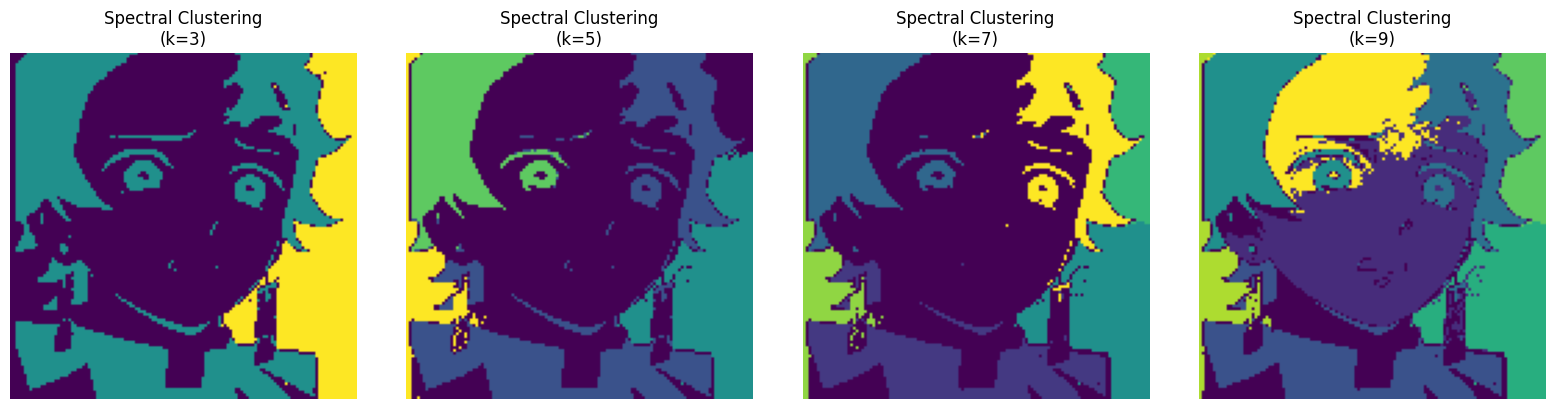

In [7]:
#Spectral Clustering
X_cpu = cp.asnumpy(X) # Convertir X (CuPy → NumPy)
spectral_segmentations = {}

for k in k_values:
    spectral = SpectralClustering(
        n_clusters=k,
        assign_labels="kmeans",
        random_state=42,
        affinity="nearest_neighbors",
        n_neighbors=10
    )
    labels_spec = spectral.fit_predict(X_cpu)
    sil_spec = silhouette_score(cudf.DataFrame(X_cpu), cudf.Series(labels_spec))
    results.append(("Spectral", k, None, float(sil_spec)))
    spectral_segmentations[k] = labels_spec

show_segmentation(spectral_segmentations, "Spectral Clustering")

## Comparación scores de inercia y silueta

In [8]:
#Crear DataFrame con todas las mediciones (Tabla comparativa)
df_results = pd.DataFrame(results, columns=["Method", "k", "Inertia", "Silhouette"])
print("\nResultados Comparativos")
display(df_results)


Resultados Comparativos


,Method,k,Inertia,Silhouette
0,KMeans,3,68630768.0,0.470192
1,KMeans,5,44177872.0,0.398315
2,KMeans,7,33659168.0,0.418102
3,KMeans,9,27954528.0,0.379842
4,DBSCAN,-,NaN,-0.618990
5,DBSCAN,-,NaN,-0.333728
6,DBSCAN,-,NaN,-0.146271
7,DBSCAN,-,NaN,-0.071527
8,Spectral,3,NaN,0.468811
9,Spectral,5,NaN,0.286968


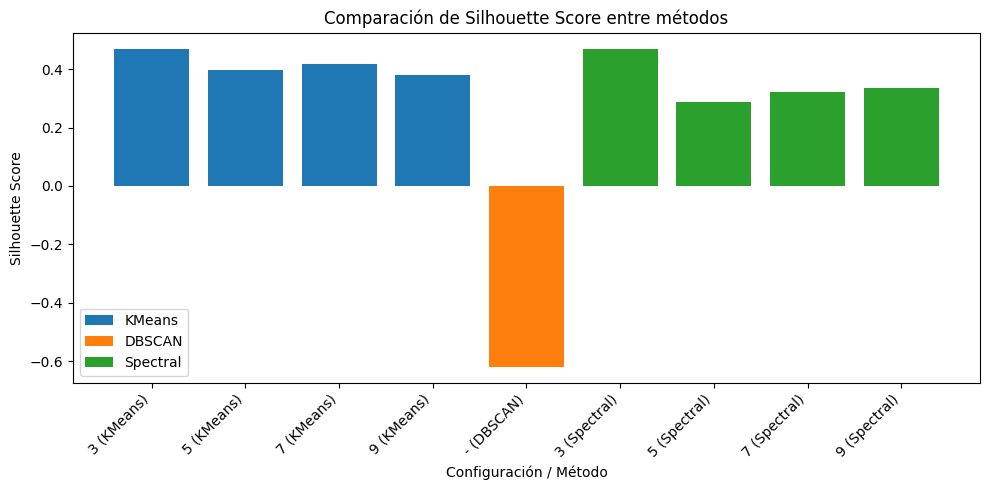

In [9]:
#Gráfica comparativa
plt.figure(figsize=(10,5))
methods = df_results["Method"].unique()
colors = plt.cm.tab10.colors  # paleta de 10 colores

for i, method in enumerate(methods):
    subset = df_results[df_results["Method"] == method]
    plt.bar(
        subset["k"].astype(str) + f" ({method})",
        subset["Silhouette"],
        color=colors[i % len(colors)],
        label=method
    )

plt.title("Comparación de Silhouette Score entre métodos")
plt.ylabel("Silhouette Score"); plt.xlabel("Configuración / Método")
plt.xticks(rotation=45, ha="right"); plt.legend(); plt.tight_layout(); plt.show()

# Ejercicio 2

Repita el punto anterior realizando una proyección 2D de los datos con PCA y UMAP (ver guía [reducción de dimensión](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/8_ReduccionDimension.ipynb))
 antes de generar las segmentaciones.

## Creación de proyecciones

In [10]:
#pca
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_gpu)

#umap
umap_2d = UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
X_umap = umap_2d.fit_transform(X_gpu)

[2025-10-26 18:41:47.412] [CUML] [info] Building knn graph using brute force (configured from build_algo='auto')


## Creación de Clustering (K-means y DBSCAN)

In [11]:
#Clustering con PCA
results_pca = []
kmeans_segmentations_pca = {}
dbscan_segmentations_pca = {}

#KMeans con PCA
for k in [3, 5, 7, 9]:
    kmeans_pca = KMeans(n_clusters=k, random_state=42)
    kmeans_pca.fit(X_pca)
    labels_pca = kmeans_pca.labels_.to_numpy()

    inertia = float(kmeans_pca.inertia_)
    sil = float(silhouette_score(X_pca, kmeans_pca.labels_))
    results_pca.append(("KMeans (PCA)", k, inertia, sil))
    kmeans_segmentations_pca[k] = labels_pca

#DBSCAN con PCA
for e in [2, 10]:
    for m in [5, 10]:
        dbscan_pca = DBSCAN(eps=e, min_samples=m)
        labels_db_pca = dbscan_pca.fit_predict(X_pca)
        unique_labels = cp.unique(labels_db_pca)
        n_clusters = len(unique_labels[unique_labels != -1])

        if n_clusters > 1:
            sil_db = float(silhouette_score(X_pca, labels_db_pca))
        else:
            sil_db = float('nan')

        results_pca.append(("DBSCAN (PCA)", "-", None, sil_db))
        dbscan_segmentations_pca[f"eps={e}, min={m}"] = labels_db_pca.to_numpy()

In [12]:
#Clustering con UMAP
results_umap = []
kmeans_segmentations_umap = {}
dbscan_segmentations_umap = {}

#KMeans con UMAP
for k in [3, 5, 7, 9]:
    kmeans_umap = KMeans(n_clusters=k, random_state=42)
    kmeans_umap.fit(X_umap)
    labels_umap = kmeans_umap.labels_.to_numpy()

    inertia = float(kmeans_umap.inertia_)
    sil = float(silhouette_score(X_umap, kmeans_umap.labels_))
    results_umap.append(("KMeans (UMAP)", k, inertia, sil))
    kmeans_segmentations_umap[k] = labels_umap

#DBSCAN con UMAP
for e in [2, 10]:
    for m in [5, 10]:
        dbscan_umap = DBSCAN(eps=e, min_samples=m)
        labels_db_umap = dbscan_umap.fit_predict(X_umap)
        unique_labels = cp.unique(labels_db_umap)
        n_clusters = len(unique_labels[unique_labels != -1])

        if n_clusters > 1:
            sil_db = float(silhouette_score(X_umap, labels_db_umap))
        else:
            sil_db = float('nan')

        results_pca.append(("DBSCAN (UMAP)", "-", None, sil_db))
        dbscan_segmentations_umap[f"eps={e}, min={m}"] = labels_db_umap.to_numpy()

## Visualización de resultados (PCA y UMAP)

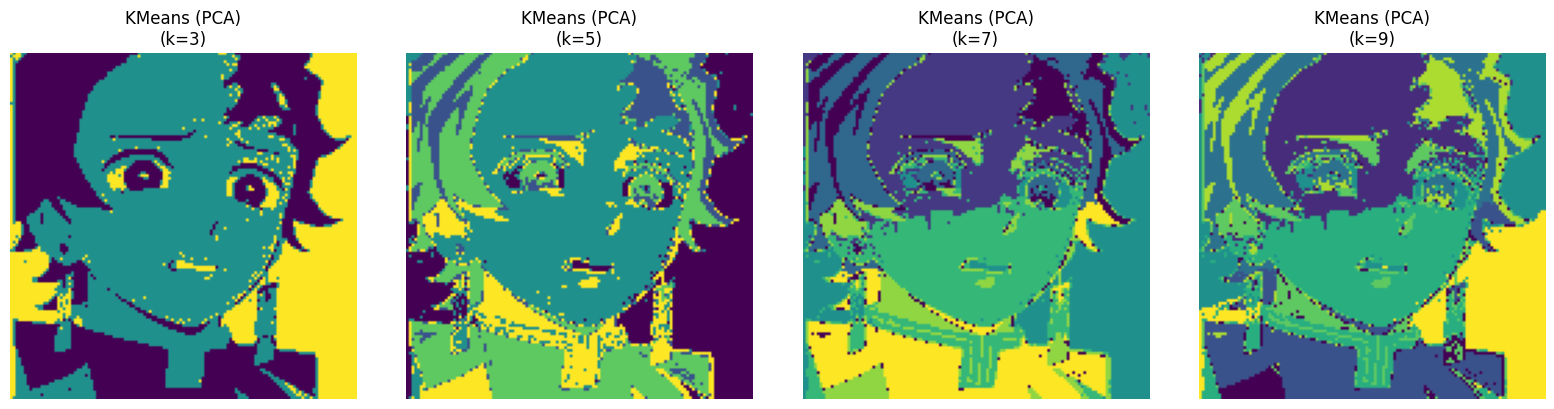

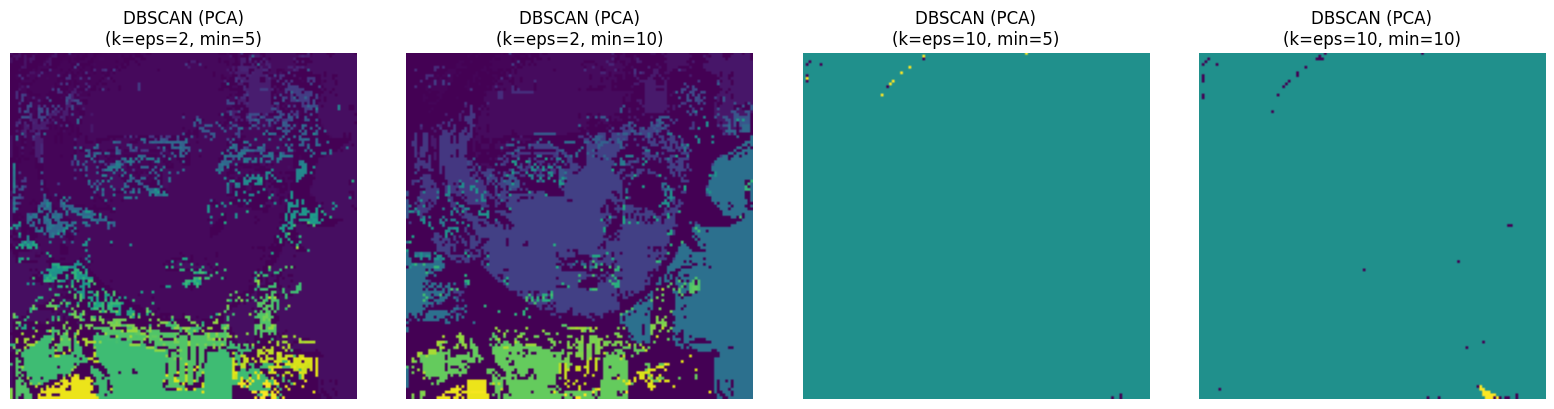

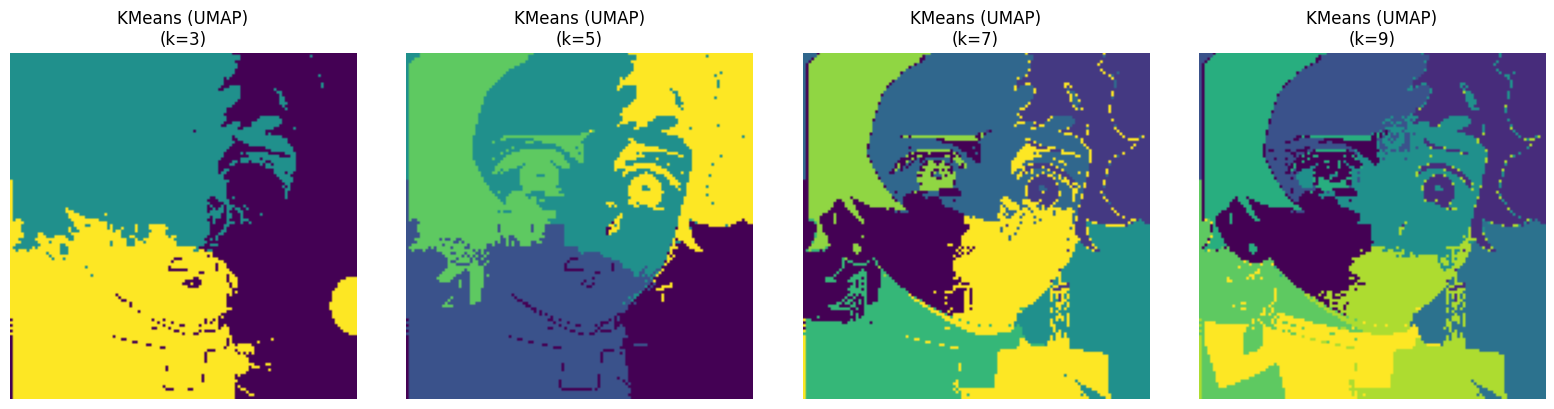

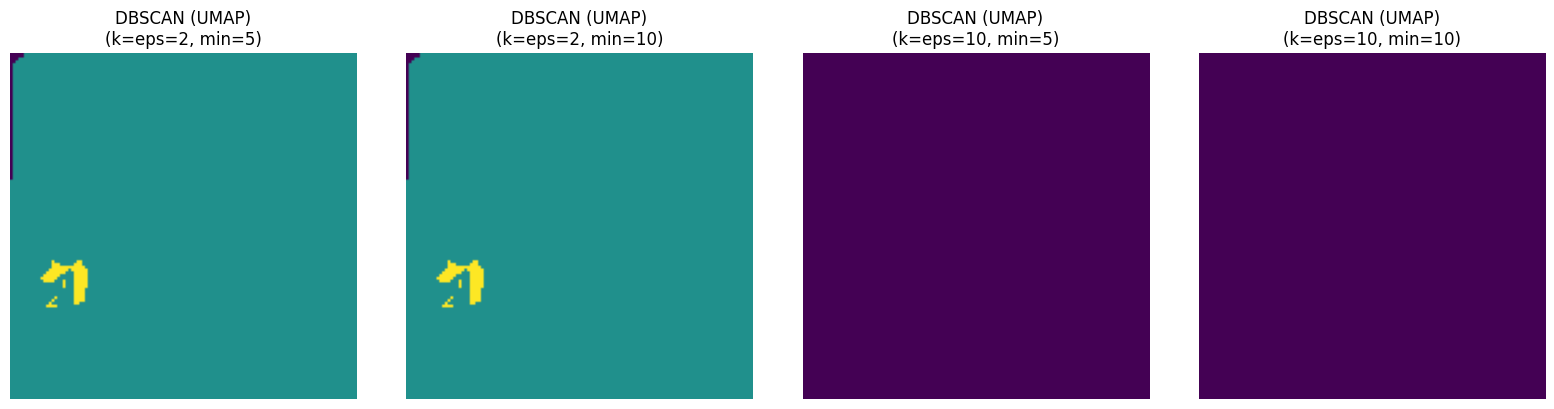

In [13]:
# Mostrar resultados PCA y UMAP
show_segmentation(kmeans_segmentations_pca, "KMeans (PCA)")
show_segmentation(dbscan_segmentations_pca, "DBSCAN (PCA)")
show_segmentation(kmeans_segmentations_umap, "KMeans (UMAP)")
show_segmentation(dbscan_segmentations_umap, "DBSCAN (UMAP)")

## Tabla y Gráfica comparativa

In [14]:
df_results_pca = pd.DataFrame(results_pca, columns=["Method", "k", "Inertia", "Silhouette"])
df_results_umap = pd.DataFrame(results_umap, columns=["Method", "k", "Inertia", "Silhouette"])
df_all = pd.concat([df_results_pca, df_results_umap])
print("\nResultados Comparativos")
display(df_all)


Resultados Comparativos


,Method,k,Inertia,Silhouette
0,KMeans (PCA),3,4.765690e+07,0.522106
1,KMeans (PCA),5,2.412572e+07,0.491304
2,KMeans (PCA),7,1.532379e+07,0.469821
3,KMeans (PCA),9,1.175204e+07,0.462531
4,DBSCAN (PCA),-,NaN,-0.423159
5,DBSCAN (PCA),-,NaN,-0.404621
6,DBSCAN (PCA),-,NaN,-0.165677
7,DBSCAN (PCA),-,NaN,-0.318535
8,DBSCAN (UMAP),-,NaN,-0.180871
9,DBSCAN (UMAP),-,NaN,-0.180871


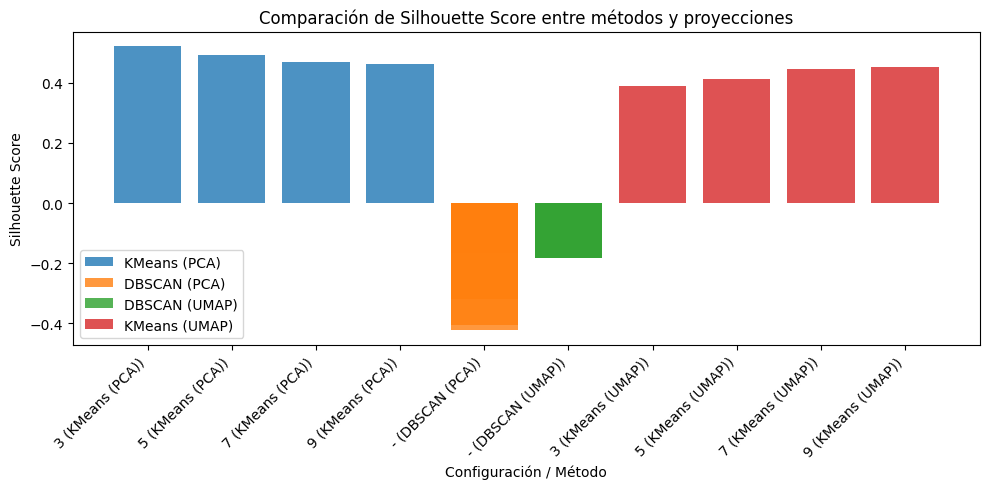

In [15]:
plt.figure(figsize=(10,5))
methods = df_all["Method"].unique()
colors = plt.cm.tab10.colors

for i, method in enumerate(methods):
    subset = df_all[df_all["Method"] == method]
    plt.bar(
        subset["k"].astype(str) + f" ({method})",
        subset["Silhouette"],
        color=colors[i % len(colors)],
        label=method,
        alpha=0.8
    )

plt.title("Comparación de Silhouette Score entre métodos y proyecciones")
plt.ylabel("Silhouette Score"); plt.xlabel("Configuración / Método")
plt.xticks(rotation=45, ha="right"); plt.legend(); plt.tight_layout()
plt.show()